In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import itertools
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import sys
sys.path.append('../')
import utils
import settings

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

In [2]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path='../')
X_reshaped_train_estimated_a, X_reshaped_train_estimated_b, X_reshaped_train_estimated_c, X_reshaped_train_observed_a, X_reshaped_train_observed_b, X_reshaped_train_observed_c, X_reshaped_test_estimated_a, X_reshaped_test_estimated_b, X_reshaped_test_estimated_c = utils.get_reshaped_files(diff_path='../')

In [3]:
train_a_copy = train_a.copy()

In [4]:
train_a_copy.set_index('time', inplace=True)
max_values_per_day = train_a_copy.resample('D').max()
max_values_per_day

,pv_measurement
time,
2019-06-02,0.00
2019-06-03,3175.92
2019-06-04,4812.06
2019-06-05,3044.80
2019-06-06,989.78
...,...
2023-04-26,2822.16
2023-04-27,1266.76
2023-04-28,4581.50


In [6]:
train_a_daily = train_a[train_a['time'].dt.strftime('%H:%M:%S').str.endswith('12:00:00')]
train_a_daily

,time,pv_measurement
14,2019-06-03 12:00:00,3175.92
38,2019-06-04 12:00:00,2464.00
62,2019-06-05 12:00:00,1572.56
86,2019-06-06 12:00:00,0.00
110,2019-06-07 12:00:00,423.94
...,...,...
33977,2023-04-26 12:00:00,2369.18
34001,2023-04-27 12:00:00,886.82
34025,2023-04-28 12:00:00,1467.40
34049,2023-04-29 12:00:00,1410.42


In [7]:
# train_a_daily_max = train_a[]

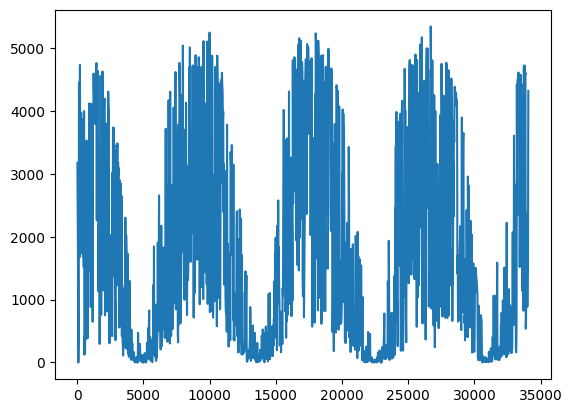

In [8]:
plt.plot(train_a_daily['pv_measurement'])

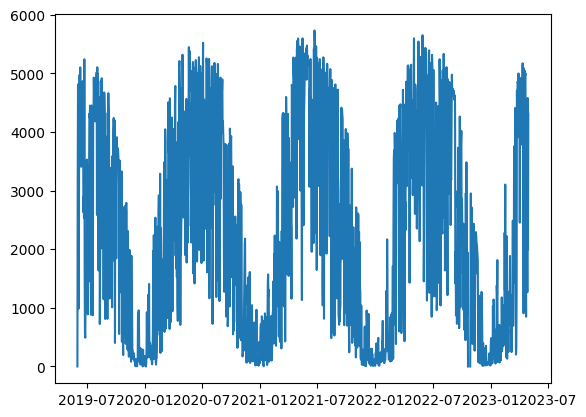

In [9]:
plt.plot(max_values_per_day['pv_measurement'])

In [10]:
train_a = train_a.rename(columns={'time': 'ds', 'pv_measurement': 'y'})[:29667] # 29667
train_a["y"] = (train_a["y"] - train_a["y"].mean()) / train_a["y"].std()
# train_a["y"] /= train_a["y"].max()

In [11]:
train_a_daily = train_a_daily.rename(columns={'time': 'ds', 'pv_measurement': 'y'})[:29667] # 29667
train_a_daily["y"] = (train_a_daily["y"] - train_a_daily["y"].mean()) / train_a_daily["y"].std()
# train_a["y"] /= train_a["y"].max()

In [12]:
max_values_per_day = max_values_per_day.reset_index()

In [13]:
max_values_per_day = max_values_per_day.rename(columns={'time': 'ds', 'pv_measurement': 'y'})[:29667] # 29667
max_values_per_day["y"] = (max_values_per_day["y"] - max_values_per_day["y"].mean()) / max_values_per_day["y"].std()
max_values_per_day

,ds,y
0,2019-06-02,-1.314747
1,2019-06-03,0.462919
2,2019-06-04,1.378720
3,2019-06-05,0.389527
4,2019-06-06,-0.760735
...,...,...
1424,2023-04-26,0.264908
1425,2023-04-27,-0.605700
1426,2023-04-28,1.249668
1427,2023-04-29,-0.198718


In [14]:
m = Prophet(changepoint_prior_scale=0.05)
m.fit(train_a)

13:34:07 - cmdstanpy - INFO - Chain [1] start processing
13:34:11 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
m = Prophet(changepoint_prior_scale=0.05)
m.fit(train_a_daily)

13:34:11 - cmdstanpy - INFO - Chain [1] start processing
13:34:11 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# future = m.make_future_dataframe(periods=66 * 24, freq='D')
future = m.make_future_dataframe(periods=66, freq='D')
future.tail()

,ds
1481,2023-07-01 12:00:00
1482,2023-07-02 12:00:00
1483,2023-07-03 12:00:00
1484,2023-07-04 12:00:00
1485,2023-07-05 12:00:00


In [17]:
forecast = m.predict(future)
forecast[['yhat']].tail()

,yhat
1481,1.544094
1482,1.951330
1483,0.842841
1484,0.529817
1485,-0.114174


/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


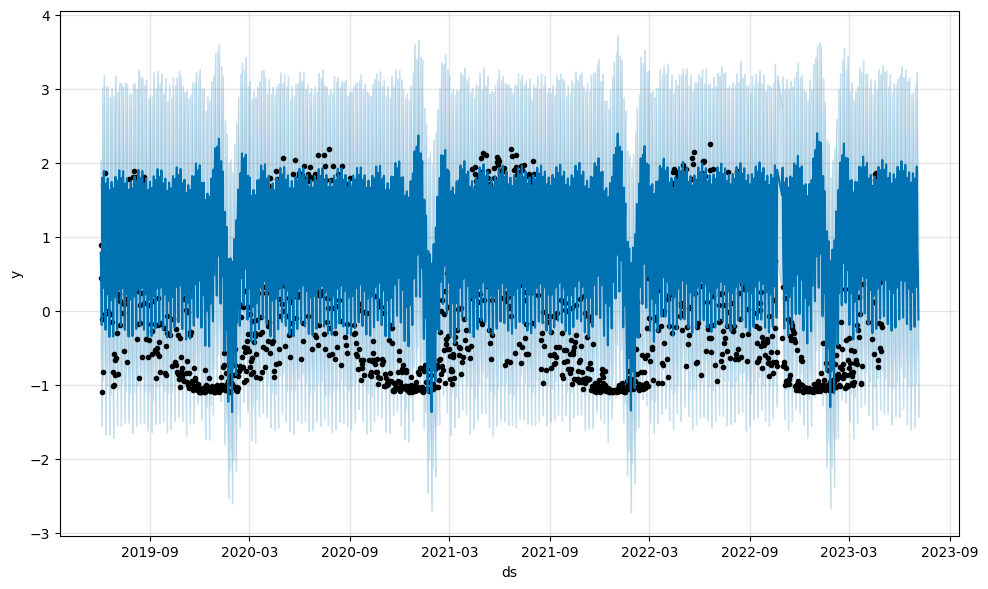

In [18]:
fig1 = m.plot(forecast) 

In [19]:
forecast[forecast['ds'] >= '2023-05-01'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1481,2023-07-01 12:00:00,1.544094,0.301268,2.842992
1482,2023-07-02 12:00:00,1.951330,0.716229,3.224994
1483,2023-07-03 12:00:00,0.842841,-0.469234,2.183800
1484,2023-07-04 12:00:00,0.529817,-0.690386,1.822250
1485,2023-07-05 12:00:00,-0.114174,-1.428914,1.117290


In [20]:
forecast['yhat']

0       0.789190
1       0.466369
2      -0.188913
3       1.800367
4       0.310687
          ...   
1481    1.544094
1482    1.951330
1483    0.842841
1484    0.529817
1485   -0.114174
Name: yhat, Length: 1486, dtype: float64

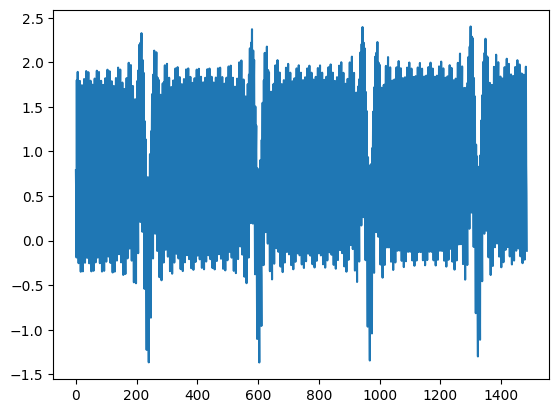

In [21]:
plt.plot(forecast['yhat'])

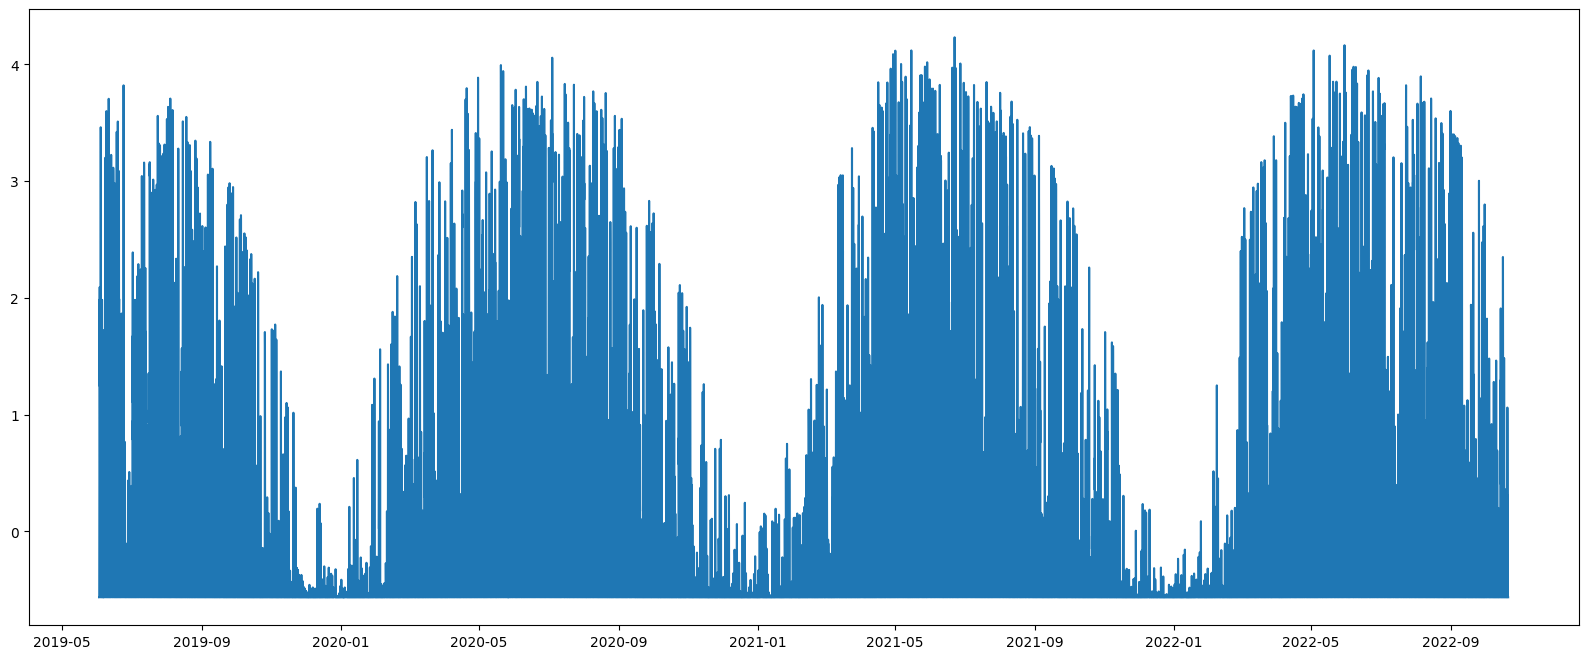

In [22]:
plt.figure(figsize=(20, 8))
plt.plot(train_a["ds"], train_a["y"])

In [34]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
df = max_values_per_day
print(all_params)
# Use cross validation to evaluate all parameters
for params in all_params:
    print('params:', params)
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    # df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

14:25:56 - cmdstanpy - INFO - Chain [1] start processing
14:25:56 - cmdstanpy - INFO - Chain [1] done processing
14:25:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:25:56 - cmdstanpy - INFO - Chain [1] start processing


[{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}, {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}, {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}, {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}, {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}, {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}, {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}, {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 

14:25:57 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:25:58 - cmdstanpy - INFO - Chain [1] start processing
14:25:58 - cmdstanpy - INFO - Chain [1] done processing
14:25:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:25:58 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:25:59 - cmdstanpy - INFO - Chain [1] start processing
14:25:59 - cmdstanpy - INFO - Chain [1] start processing
14:25:59 - cmdstanpy - INFO - Chain [1] 

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


14:26:05 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:26:06 - cmdstanpy - INFO - Chain [1] start processing
14:26:06 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:26:06 - cmdstanpy - INFO - Chain [1] start processing
14:26:06 - cmdstanpy - INFO - Chain [1] done processing
14:26:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:26:06 - cmdstanpy - INFO - Chain [1] done processing
14:26:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
1

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


14:26:16 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:26:17 - cmdstanpy - INFO - Chain [1] start processing
14:26:17 - cmdstanpy - INFO - Chain [1] start processing
14:26:17 - cmdstanpy - INFO - Chain [1] start processing
14:26:17 - cmdstanpy - INFO - Chain [1] start processing
14:26:17 - cmdstanpy - INFO - Chain [1] done processing
14:26:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
14:26:17 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
14:26:17 - cmdstanpy - INFO - Chain [1] d

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


14:26:24 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:26:25 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:26:25 - cmdstanpy - INFO - Chain [1] done processing
14:26:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:26:25 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:26:25 - cmdstanpy - INFO - Chain [1] start processing
14:26:25 - cmdstanpy - INFO - Chain [1] start processing
14:26:25 - cmdstanpy - INFO - Chain [1] start processing
14:26:25 - cmdstanpy - INFO - Chain [1] s

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


14:26:34 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:26:35 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:26:35 - cmdstanpy - INFO - Chain [1] start processing
14:26:35 - cmdstanpy - INFO - Chain [1] start processing
14:26:35 - cmdstanpy - INFO - Chain [1] done processing
14:26:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:26:35 - cmdstanpy - INFO - Chain [1] done processing
14:26:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
1

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


14:26:42 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:26:43 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:26:43 - cmdstanpy - INFO - Chain [1] done processing
14:26:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:26:43 - cmdstanpy - INFO - Chain [1] start processing
14:26:43 - cmdstanpy - INFO - Chain [1] start processing
14:26:43 - cmdstanpy - INFO - Chain [1] start processing
14:26:43 - cmdstanpy - INFO - Chain [1] done processing
14:26:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


14:26:52 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:26:53 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:26:53 - cmdstanpy - INFO - Chain [1] start processing
14:26:53 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:26:53 - cmdstanpy - INFO - Chain [1] done processing
14:26:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:26:53 - cmdstanpy - INFO - Chain [1] done processing
14:26:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opt

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


14:27:00 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:27:01 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:27:01 - cmdstanpy - INFO - Chain [1] start processing
14:27:01 - cmdstanpy - INFO - Chain [1] done processing
14:27:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:27:01 - cmdstanpy - INFO - Chain [1] start processing
14:27:01 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:27:01 - cmdstanpy - INFO - Chain [1] done processing
14:27:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


14:27:10 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:27:12 - cmdstanpy - INFO - Chain [1] start processing
14:27:12 - cmdstanpy - INFO - Chain [1] done processing
14:27:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
14:27:12 - cmdstanpy - INFO - Chain [1] start processing
14:27:12 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:27:12 - cmdstanpy - INFO - Chain [1] done processing
14:27:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Im

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


14:28:30 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:28:31 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
14:28:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
14:28:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opt

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


14:30:19 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:30:20 - cmdstanpy - INFO - Chain [1] start processing
14:30:20 - cmdstanpy - INFO - Chain [1] done processing
14:30:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:30:20 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:30:20 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:30:20 - cmdstanpy - INFO - Chain [1] start processing
14:30:20 - cmdstanpy - INFO - Chain [1] start processing
14:30:20 - cmdstanpy - INFO - Chain [1] d

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


14:31:38 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:31:39 - cmdstanpy - INFO - Chain [1] start processing
14:31:39 - cmdstanpy - INFO - Chain [1] done processing
14:31:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:31:39 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:31:39 - cmdstanpy - INFO - Chain [1] start processing
14:31:39 - cmdstanpy - INFO - Chain [1] done processing
14:31:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
14:31:39 - cmdstanpy - INFO - Chain [1] start processing
Im

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


14:33:28 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:33:29 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - ERROR - Chain [1] 

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


14:34:47 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:34:49 - cmdstanpy - INFO - Chain [1] start processing
14:34:49 - cmdstanpy - INFO - Chain [1] done processing
14:34:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:34:49 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:34:49 - cmdstanpy - INFO - Chain [1] start processing
14:34:49 - cmdstanpy - INFO - Chain [1] done processing
14:34:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:34:49 - cmdstanpy - INFO - Chain [1] start processing
14

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


14:36:37 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:36:38 - cmdstanpy - INFO - Chain [1] start processing
14:36:38 - cmdstanpy - INFO - Chain [1] done processing
14:36:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:36:38 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:36:39 - cmdstanpy - INFO - Chain [1] start processing
14:36:39 - cmdstanpy - INFO - Chain [1] start processing
14:36:39 - cmdstanpy - INFO - Chain [1] 

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


14:37:57 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:37:58 - cmdstanpy - INFO - Chain [1] start processing
14:37:58 - cmdstanpy - INFO - Chain [1] done processing
14:37:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:37:58 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:37:59 - cmdstanpy - INFO - Chain [1] start processing
14:37:59 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:37:59 - cmdstanpy - INFO - Chain [1] 

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


14:39:53 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] done processing
14:39:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] done processing
14:39:54 - cmdstanpy - INFO - Chain [1] sta

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


14:40:17 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:40:19 - cmdstanpy - INFO - Chain [1] start processing
14:40:19 - cmdstanpy - INFO - Chain [1] done processing
14:40:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:40:19 - cmdstanpy - INFO - Chain [1] start processing
14:40:19 - cmdstanpy - INFO - Chain [1] start processing
14:40:19 - cmdstanpy - INFO - Chain [1] start processing
14:40:19 - cmdstanpy - INFO - Chain [1] start processing
14:40:19 - cmdstanpy - INFO - Chain [1] done processing
14:40:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


14:41:27 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:41:28 - cmdstanpy - INFO - Chain [1] start processing
14:41:28 - cmdstanpy - INFO - Chain [1] done processing
14:41:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:41:28 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:41:28 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:41:28 - cmdstanpy - INFO - Chain [1] done processing
14:41:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
14:41:28 - cmdstanpy - INFO - Chain [1] start processing
Im

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


14:41:51 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:41:53 - cmdstanpy - INFO - Chain [1] start processing
14:41:53 - cmdstanpy - INFO - Chain [1] done processing
14:41:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
14:41:53 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:41:53 - cmdstanpy - INFO - Chain [1] start processing
14:41:53 - cmdstanpy - INFO - Chain [1] done processing
14:41:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
14:41:53 - cmdstanpy - INFO - Chain [1] start processing
14

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


14:43:01 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:43:02 - cmdstanpy - INFO - Chain [1] start processing
14:43:02 - cmdstanpy - INFO - Chain [1] done processing
14:43:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:43:02 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:43:02 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:43:02 - cmdstanpy - INFO - Chain [1] done processing
14:43:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
I

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


14:43:25 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:43:26 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:43:26 - cmdstanpy - INFO - Chain [1] start processing
14:43:26 - cmdstanpy - INFO - Chain [1] done processing
14:43:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:43:26 - cmdstanpy - INFO - Chain [1] done processing
14:43:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


14:44:35 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:44:36 - cmdstanpy - INFO - Chain [1] start processing
14:44:36 - cmdstanpy - INFO - Chain [1] done processing
14:44:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:44:36 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:44:36 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:44:36 - cmdstanpy - INFO - Chain [1] start processing
14:44:36 - cmdstanpy - INFO - Chain [1] done processing
14:44:36 - cmdstanpy - INFO - Chain [1] start processing
14:44:36 - cmdstanpy - ERROR - Chain [1] er

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


14:44:42 - cmdstanpy - INFO - Chain [1] start processing
14:44:59 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:45:01 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:45:01 - cmdstanpy - INFO - Chain [1] done processing
14:45:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:45:01 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:45:01 - cmdstanpy - INFO - Chain [1] start processing
14:45:01 - cmdstanpy - INFO - Chain [1] start processing
14:45:01 - cmdstanpy - INFO - Chain [1] s

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


14:46:08 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:46:09 - cmdstanpy - INFO - Chain [1] start processing
14:46:09 - cmdstanpy - INFO - Chain [1] done processing
14:46:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:46:09 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:46:09 - cmdstanpy - INFO - Chain [1] start processing
14:46:09 - cmdstanpy - INFO - Chain [1] start processing
14:46:09 - cmdstanpy - INFO - Chain [1] 

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


14:46:17 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:46:18 - cmdstanpy - INFO - Chain [1] start processing
14:46:18 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:46:18 - cmdstanpy - INFO - Chain [1] done processing
14:46:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:46:18 - cmdstanpy - INFO - Chain [1] done processing
14:46:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


14:47:19 - cmdstanpy - INFO - Chain [1] start processing
14:47:20 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:47:21 - cmdstanpy - INFO - Chain [1] start processing
14:47:21 - cmdstanpy - INFO - Chain [1] done processing
14:47:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:47:21 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:47:21 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:47:21 - cmdstanpy - INFO - Chain [1] done processing
14:47:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


14:47:27 - cmdstanpy - INFO - Chain [1] start processing
14:47:29 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:47:30 - cmdstanpy - INFO - Chain [1] start processing
14:47:30 - cmdstanpy - INFO - Chain [1] start processing
14:47:30 - cmdstanpy - INFO - Chain [1] done processing
14:47:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:47:30 - cmdstanpy - INFO - Chain [1] start processing
14:47:30 - cmdstanpy - INFO - Chain [1] done processing
14:47:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


14:48:33 - cmdstanpy - INFO - Chain [1] start processing
14:48:34 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:48:35 - cmdstanpy - INFO - Chain [1] start processing
14:48:35 - cmdstanpy - INFO - Chain [1] done processing
14:48:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:48:35 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:48:36 - cmdstanpy - INFO - Chain [1] start processing
14:48:36 - cmdstanpy - INFO - Chain [1] start processing
14:48:36 - cmdstanpy - INFO - Chain [1] done processing
14:48:36 - cmdstanpy - ERROR - Chain [1] er

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


14:48:43 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:48:45 - cmdstanpy - INFO - Chain [1] start processing
14:48:45 - cmdstanpy - INFO - Chain [1] start processing
14:48:45 - cmdstanpy - INFO - Chain [1] done processing
14:48:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:48:45 - cmdstanpy - INFO - Chain [1] start processing
14:48:45 - cmdstanpy - INFO - Chain [1] start processing
14:48:45 - cmdstanpy - INFO - Chain [1] 

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


14:49:45 - cmdstanpy - INFO - Chain [1] start processing
14:49:46 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:49:47 - cmdstanpy - INFO - Chain [1] start processing
14:49:47 - cmdstanpy - INFO - Chain [1] done processing
14:49:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:49:47 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:49:47 - cmdstanpy - INFO - Chain [1] start processing
14:49:47 - cmdstanpy - INFO - Chain [1] 

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


14:49:55 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:49:56 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:49:56 - cmdstanpy - INFO - Chain [1] start processing
14:49:56 - cmdstanpy - INFO - Chain [1] done processing
14:49:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:49:56 - cmdstanpy - INFO - Chain [1] done processing
14:49:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:49:56 - cmdstanpy - INFO - Chain [1] start processing
1

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
14:51:00 - cmdstanpy - INFO - Chain [1] start processing
14:51:00 - cmdstanpy - INFO - Chain [1] done processing
14:51:00 - cmdstanpy - INFO - Chain [1] start processing
14:51:00 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:51:00 - cmdstanpy - INFO - Chain [1] start processing
14:51:00 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:00 - cmdstanpy - INFO - Chain [1] done processing
14:51:00 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:01 - cmdstanpy - INFO - Chain [1] start processing
14:51:01 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Int

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:03 - cmdstanpy - INFO - Chain [1] start processing
14:51:03 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:03 - cmdstanpy - INFO - Chain [1] start processing
14:51:03 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:51:03 - cmdstanpy - INFO - Chain [1] done processing
14:51:03 - cmdstanpy - INFO - Chain [1] start processing
14:51:03 - cmdstanpy - INFO - Chain [1] start processing
14:51:03 - cmdstanpy - INFO - Chain [1] start processing
14:51:03 - cmdstanpy - INFO - Chain [1] done processing
14:51:03 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:06 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:06 - cmdstanpy - INFO - Chain [1] start processing
14:51:06 - cmdstanpy - INFO - Chain [1] start processing
14:51:06 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:51:06 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:51:06 - cmdstanpy - INFO - Chain [1] start processing
14:51:06 - cmdstanpy - INFO - Chain [1] start processing
14:51:06 - cmdstanpy - INFO - Chain [1] done processing
14:51:06 - cmdstanpy - INFO - Chain [1] done processing
14:51:06 - cmdstanpy - INFO - Chain [1] start processing
14:51:06 - cmdstanpy - INFO 

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:09 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:09 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:09 - cmdstanpy - INFO - Chain [1] done processing
14:51:09 - cmdstanpy - INFO - Chain [1] start processing
14:51:09 - cmdstanpy - INFO - Chain [1] done processing
14:51:09 - cmdstanpy - INFO - Chain [1] start processing
14:51:09 - cmdstanpy - INFO - Chain [1] start processing
14:51:09 - cmdstanpy - INFO - Chain [1] start processing
14:51:09 - cmdstanpy - INFO - Chain [1] start processing
14:51:09 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:11 - cmdstanpy - INFO - Chain [1] start processing
14:51:11 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:11 - cmdstanpy - INFO - Chain [1] start processing
14:51:11 - cmdstanpy - INFO - Chain [1] done processing
14:51:11 - cmdstanpy - INFO - Chain [1] start processing
14:51:11 - cmdstanpy - INFO - Chain [1] done processing
14:51:11 - cmdstanpy - INFO - Chain [1] start processing
14:51:11 - cmdstanpy - INFO - Chain [1] done processing
14:51:11 - cmdstanpy - INFO - Chain [1] done processing
14:51:11 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:14 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:14 - cmdstanpy - INFO - Chain [1] start processing
14:51:14 - cmdstanpy - INFO - Chain [1] start processing
14:51:14 - cmdstanpy - INFO - Chain [1] done processing
14:51:14 - cmdstanpy - INFO - Chain [1] start processing
14:51:14 - cmdstanpy - INFO - Chain [1] done processing
14:51:14 - cmdstanpy - INFO - Chain [1] done processing
14:51:14 - cmdstanpy - INFO - Chain [1] done processing
14:51:14 - cmdstanpy - INFO - Chain [1] start processing
14:51:14 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:14 - cmdstanpy - INFO 

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:17 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:17 - cmdstanpy - INFO - Chain [1] start processing
14:51:17 - cmdstanpy - INFO - Chain [1] start processing
14:51:17 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:17 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:51:17 - cmdstanpy - INFO - Chain [1] done processing
14:51:17 - cmdstanpy - INFO - Chain [1] done processing
14:51:17 - cmdstanpy - INFO - Chain [1] done processing
14:51:17 - cmdstanpy - INFO - Chain [1] start processing
14:51:17 - cmdstanpy - INFO - Chain [1] done processing
14:51:17 - cmdstanpy - INFO -

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:20 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:20 - cmdstanpy - INFO - Chain [1] start processing
14:51:20 - cmdstanpy - INFO - Chain [1] done processing
14:51:20 - cmdstanpy - INFO - Chain [1] done processing
14:51:20 - cmdstanpy - INFO - Chain [1] start processing
14:51:20 - cmdstanpy - INFO - Chain [1] start processing
14:51:20 - cmdstanpy - INFO - Chain [1] start processing
14:51:20 - cmdstanpy - INFO - Chain [1] done processing
14:51:20 - cmdstanpy - INFO - Chain [1] start processing
14:51:20 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
14:51:23 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:23 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:23 - cmdstanpy - INFO - Chain [1] start processing
14:51:23 - cmdstanpy - INFO - Chain [1] start processing
14:51:23 - cmdstanpy - INFO - Chain [1] start processing
14:51:23 - cmdstanpy - INFO - Chain [1] done processing
14:51:23 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:23 - cmdstanpy - INFO - Chain [1] done processing
14:51:23 - cmdstanpy - INFO - Chain [1] done processing
14:51:23 - cmdstanpy - INFO - Chain [1] start processing
14:51:23 - cmdstanpy - INFO 

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
14:51:26 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:26 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:51:26 - cmdstanpy - INFO - Chain [1] start processing
14:51:26 - cmdstanpy - INFO - Chain [1] start processing
14:51:26 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:26 - cmdstanpy - INFO - Chain [1] done processing
14:51:26 - cmdstanpy - INFO - Chain [1] done processing
14:51:26 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:51:26 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:26 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:29 - cmdstanpy - INFO - Chain [1] start processing
14:51:29 - cmdstanpy - INFO - Chain [1] done processing
14:51:29 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:29 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:29 - cmdstanpy - INFO - Chain [1] start processing
14:51:29 - cmdstanpy - INFO - Chain [1] done processing
14:51:29 - cmdstanpy - INFO - Chain [1] start processing
14:51:29 - cmdstanpy - INFO - Chain [1] done processing
14:51:29 - cmdstanpy - INFO - Chain [1] start processing
14:51:29 - cmdstanpy - INFO - Chain [1] start processing
14:51:29 - cmdstanpy - INFO - Chain [1] done processing
14:51:29 - cmdstanpy - INFO - 

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:32 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:32 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:32 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:51:32 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:32 - cmdstanpy - INFO - Chain [1] start processing
14:51:32 - cmdstanpy - INFO - Chain [1] start processing
14:51:32 - cmdstanpy - INFO - Chain [1] done processing
14:51:32 - cmdstanpy - INFO - Chain [1] done processing
14:51:32 - cmdstanpy - INFO - Chain [1] start processing
14:51:32 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:35 - cmdstanpy - INFO - Chain [1] start processing
14:51:35 - cmdstanpy - INFO - Chain [1] start processing
14:51:35 - cmdstanpy - INFO - Chain [1] start processing
14:51:35 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:35 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:35 - cmdstanpy - INFO - Chain [1] done processing
14:51:35 - cmdstanpy - INFO - Chain [1] done processing
14:51:35 - cmdstanpy - INFO - Chain [1] done processing
14:51:35 - cmdstanpy - INFO - Chain [1] done processing
14:51:35 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:38 - cmdstanpy - INFO - Chain [1] start processing
14:51:38 - cmdstanpy - INFO - Chain [1] start processing
14:51:38 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:38 - cmdstanpy - INFO - Chain [1] done processing
14:51:38 - cmdstanpy - INFO - Chain [1] done processing
14:51:38 - cmdstanpy - INFO - Chain [1] done processing
14:51:38 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:38 - cmdstanpy - INFO - Chain [1] start processing
14:51:38 - cmdstanpy - INFO - Chain [1] start processing
14:51:38 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:41 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:41 - cmdstanpy - INFO - Chain [1] start processing
14:51:41 - cmdstanpy - INFO - Chain [1] start processing
14:51:41 - cmdstanpy - INFO - Chain [1] done processing
14:51:41 - cmdstanpy - INFO - Chain [1] done processing
14:51:41 - cmdstanpy - INFO - Chain [1] done processing
14:51:41 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:41 - cmdstanpy - INFO - Chain [1] start processing
14:51:41 - cmdstanpy - INFO - Chain [1] start processing
14:51:41 - cmdstanpy - INFO - Chain [1] done processing
14:51:41 - cmdstanpy - INFO 

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:44 - cmdstanpy - INFO - Chain [1] start processing
14:51:44 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:44 - cmdstanpy - INFO - Chain [1] done processing
14:51:44 - cmdstanpy - INFO - Chain [1] done processing
14:51:44 - cmdstanpy - INFO - Chain [1] start processing
14:51:44 - cmdstanpy - INFO - Chain [1] start processing
14:51:44 - cmdstanpy - INFO - Chain [1] start processing
14:51:44 - cmdstanpy - INFO - Chain [1] start processing
14:51:44 - cmdstanpy - INFO - Chain [1] start processing
14:51:44 - cmdstanpy - INFO - Chain [1] done processing
14:51:44 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:51:47 - cmdstanpy - INFO - Chain [1] done processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] done processing
14:51:47 - cmdstanpy - INFO - Chain [1] done processing
14:51:47 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] done processing
14:51:50 - cmdstanpy - INFO - Chain [1] done processing
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] done processing
14:51:50 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:52 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:52 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:52 - cmdstanpy - INFO - Chain [1] done processing
14:51:52 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] start processing
14:51:53 - cmdstanpy - INFO - Chain [1] start processing
14:51:53 - cmdstanpy - INFO - Chain [1] start processing
14:51:53 - cmdstanpy - INFO - Chain [1] done processing
14:51:53 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:51:53 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:55 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:55 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:55 - cmdstanpy - INFO - Chain [1] done processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing
14:51:55 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:55 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:55 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:55 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:58 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:51:58 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:51:58 - cmdstanpy - INFO - Chain [1] start processing
14:51:58 - cmdstanpy - INFO - Chain [1] done processing
14:51:58 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:51:58 - cmdstanpy - INFO - Chain [1] done processing
14:51:58 - cmdstanpy - INFO - Chain [1] start processing
14:51:58 - cmdstanpy - INFO - Chain [1] start processing
14:51:58 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:51:58 - cmdstanpy - INFO - Chain [1] start processing
14:51:58 - cmdstanpy - INFO 

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:01 - cmdstanpy - INFO - Chain [1] start processing
14:52:01 - cmdstanpy - INFO - Chain [1] start processing
14:52:01 - cmdstanpy - INFO - Chain [1] start processing
14:52:01 - cmdstanpy - INFO - Chain [1] done processing
14:52:01 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:52:01 - cmdstanpy - INFO - Chain [1] done processing
14:52:01 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:01 - cmdstanpy - INFO - Chain [1] done processing
14:52:01 - cmdstanpy - INFO - Chain [1] start processing
14:52:01 - cmdstanpy - INFO - Chain [1] start processing
14:52:01 - cmdstanpy - INFO 

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:04 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:04 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:04 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:52:04 - cmdstanpy - INFO - Chain [1] start processing
14:52:04 - cmdstanpy - INFO - Chain [1] start processing
14:52:04 - cmdstanpy - INFO - Chain [1] done processing
14:52:04 - cmdstanpy - INFO - Chain [1] done processing
14:52:04 - cmdstanpy - INFO - Chain [1] start processing
14:52:04 - cmdstanpy - INFO - Chain [1] start processing
14:52:04 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
14:52:06 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:06 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:06 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:06 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:06 - cmdstanpy - INFO - Chain [1] done processing
14:52:06 - cmdstanpy - INFO - Chain [1] start processing
14:52:06 - cmdstanpy - INFO - Chain [1] start processing
14:52:07 - cmdstanpy - INFO - Chain [1] done processing
14:52:07 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:07 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:10 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:10 - cmdstanpy - INFO - Chain [1] start processing
14:52:10 - cmdstanpy - INFO - Chain [1] start processing
14:52:10 - cmdstanpy - INFO - Chain [1] done processing
14:52:10 - cmdstanpy - INFO - Chain [1] start processing
14:52:10 - cmdstanpy - INFO - Chain [1] start processing
14:52:10 - cmdstanpy - INFO - Chain [1] start processing
14:52:10 - cmdstanpy - INFO - Chain [1] done processing
14:52:10 - cmdstanpy - INFO - Chain [1] done processing
14:52:10 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:13 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:13 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:52:13 - cmdstanpy - INFO - Chain [1] start processing
14:52:13 - cmdstanpy - INFO - Chain [1] start processing
14:52:13 - cmdstanpy - INFO - Chain [1] start processing
14:52:13 - cmdstanpy - INFO - Chain [1] start processing
14:52:13 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:52:13 - cmdstanpy - INFO - Chain [1] done processing
14:52:13 - cmdstanpy - INFO - Chain [1] done processing
14:52:13 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:16 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:16 - cmdstanpy - INFO - Chain [1] start processing
14:52:16 - cmdstanpy - INFO - Chain [1] done processing
14:52:16 - cmdstanpy - INFO - Chain [1] start processing
14:52:16 - cmdstanpy - INFO - Chain [1] done processing
14:52:16 - cmdstanpy - INFO - Chain [1] start processing
14:52:16 - cmdstanpy - INFO - Chain [1] start processing
14:52:16 - cmdstanpy - INFO - Chain [1] start processing
14:52:16 - cmdstanpy - INFO - Chain [1] start processing
14:52:16 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:19 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:19 - cmdstanpy - INFO - Chain [1] start processing
14:52:19 - cmdstanpy - INFO - Chain [1] start processing
14:52:19 - cmdstanpy - INFO - Chain [1] start processing
14:52:19 - cmdstanpy - INFO - Chain [1] done processing
14:52:19 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:52:19 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:52:19 - cmdstanpy - INFO - Chain [1] done processing
14:52:19 - cmdstanpy - INFO - Chain [1] start processing
14:52:19 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:22 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:22 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:22 - cmdstanpy - INFO - Chain [1] start processing
14:52:22 - cmdstanpy - INFO - Chain [1] done processing
14:52:22 - cmdstanpy - INFO - Chain [1] start processing
14:52:22 - cmdstanpy - INFO - Chain [1] start processing
14:52:22 - cmdstanpy - INFO - Chain [1] done processing
14:52:22 - cmdstanpy - INFO - Chain [1] start processing
14:52:22 - cmdstanpy - INFO - Chain [1] done processing
14:52:22 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
14:52:25 - cmdstanpy - INFO - Chain [1] start processing
14:52:25 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:52:25 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:25 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:25 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:52:25 - cmdstanpy - INFO - Chain [1] done processing
14:52:25 - cmdstanpy - INFO - Chain [1] start processing
14:52:25 - cmdstanpy - INFO - Chain [1] start processing
14:52:25 - cmdstanpy - INFO - Chain [1] start processing
14:52:25 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:28 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:28 - cmdstanpy - INFO - Chain [1] done processing
14:52:28 - cmdstanpy - INFO - Chain [1] start processing
14:52:28 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:28 - cmdstanpy - INFO - Chain [1] start processing
14:52:28 - cmdstanpy - INFO - Chain [1] done processing
14:52:28 - cmdstanpy - INFO - Chain [1] done processing
14:52:28 - cmdstanpy - INFO - Chain [1] start processing
14:52:28 - cmdstanpy - INFO - Chain [1] done processing
14:52:28 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:31 - cmdstanpy - INFO - Chain [1] start processing
14:52:31 - cmdstanpy - INFO - Chain [1] start processing
14:52:31 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:31 - cmdstanpy - INFO - Chain [1] start processing
14:52:31 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:52:31 - cmdstanpy - INFO - Chain [1] done processing
14:52:31 - cmdstanpy - INFO - Chain [1] done processing
14:52:31 - cmdstanpy - INFO - Chain [1] done processing
14:52:31 - cmdstanpy - INFO - Chain [1] start processing
14:52:31 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:33 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:33 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:34 - cmdstanpy - INFO - Chain [1] done processing
14:52:34 - cmdstanpy - INFO - Chain [1] start processing
14:52:34 - cmdstanpy - INFO - Chain [1] done processing
14:52:34 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:34 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:34 - cmdstanpy - INFO - Chain [1] done processing
14:52:34 - cmdstanpy - INFO - Chain [1] start processing
14:52:34 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] done processing
14:52:37 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:40 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:40 - cmdstanpy - INFO - Chain [1] start processing
14:52:40 - cmdstanpy - INFO - Chain [1] start processing
14:52:40 - cmdstanpy - INFO - Chain [1] done processing
14:52:40 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:40 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:40 - cmdstanpy - INFO - Chain [1] start processing
14:52:40 - cmdstanpy - INFO - Chain [1] done processing
14:52:40 - cmdstanpy - INFO - Chain [1] done processing
14:52:40 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:43 - cmdstanpy - INFO - Chain [1] start processing
14:52:43 - cmdstanpy - INFO - Chain [1] start processing
14:52:43 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:43 - cmdstanpy - INFO - Chain [1] start processing
14:52:43 - cmdstanpy - INFO - Chain [1] start processing
14:52:43 - cmdstanpy - INFO - Chain [1] done processing
14:52:43 - cmdstanpy - INFO - Chain [1] start processing
14:52:43 - cmdstanpy - INFO - Chain [1] done processing
14:52:43 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:52:43 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:46 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:46 - cmdstanpy - INFO - Chain [1] start processing
14:52:46 - cmdstanpy - INFO - Chain [1] start processing
14:52:46 - cmdstanpy - INFO - Chain [1] done processing
14:52:46 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:46 - cmdstanpy - INFO - Chain [1] start processing
14:52:46 - cmdstanpy - INFO - Chain [1] done processing
14:52:46 - cmdstanpy - INFO - Chain [1] done processing
14:52:46 - cmdstanpy - INFO - Chain [1] done processing
14:52:46 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:49 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:49 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:49 - cmdstanpy - INFO - Chain [1] start processing
14:52:49 - cmdstanpy - INFO - Chain [1] start processing
14:52:49 - cmdstanpy - INFO - Chain [1] done processing
14:52:49 - cmdstanpy - INFO - Chain [1] done processing
14:52:49 - cmdstanpy - INFO - Chain [1] start processing
14:52:49 - cmdstanpy - INFO - Chain [1] start processing
14:52:49 - cmdstanpy - INFO - Chain [1] done processing
14:52:49 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:52 - cmdstanpy - INFO - Chain [1] start processing
14:52:52 - cmdstanpy - INFO - Chain [1] start processing
14:52:52 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:52 - cmdstanpy - INFO - Chain [1] start processing
14:52:52 - cmdstanpy - INFO - Chain [1] start processing
14:52:52 - cmdstanpy - INFO - Chain [1] done processing
14:52:52 - cmdstanpy - INFO - Chain [1] done processing
14:52:52 - cmdstanpy - INFO - Chain [1] done processing
14:52:52 - cmdstanpy - INFO - Chain [1] start processing
14:52:52 - cmdstanpy - INFO - Chain [1] done processing
14:52:52 - cmdstanpy - INFO 

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
14:52:55 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:52:55 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:55 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:55 - cmdstanpy - INFO - Chain [1] start processing
14:52:55 - cmdstanpy - INFO - Chain [1] start processing
14:52:55 - cmdstanpy - INFO - Chain [1] start processing
14:52:55 - cmdstanpy - INFO - Chain [1] start processing
14:52:55 - cmdstanpy - INFO - Chain [1] start processing
14:52:55 - cmdstanpy - INFO - Chain [1] done processing
14:52:55 - cmdstanpy - INFO - Chain [1] done processing
14:52:55 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:58 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:58 - cmdstanpy - INFO - Chain [1] done processing
14:52:58 - cmdstanpy - INFO - Chain [1] done processing
14:52:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:58 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:52:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:58 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:01 - cmdstanpy - INFO - Chain [1] start processing
14:53:01 - cmdstanpy - INFO - Chain [1] start processing
14:53:01 - cmdstanpy - INFO - Chain [1] start processing
14:53:01 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:01 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:01 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:01 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:01 - cmdstanpy - INFO - Chain [1] start processing
14:53:01 - cmdstanpy - INFO - Chain [1] start processing
14:53:01 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:04 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:04 - cmdstanpy - INFO - Chain [1] start processing
14:53:04 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:04 - cmdstanpy - INFO - Chain [1] done processing
14:53:04 - cmdstanpy - INFO - Chain [1] start processing
14:53:04 - cmdstanpy - INFO - Chain [1] start processing
14:53:04 - cmdstanpy - INFO - Chain [1] done processing
14:53:04 - cmdstanpy - INFO - Chain [1] done processing
14:53:05 - cmdstanpy - INFO - Chain [1] start processing
14:53:05 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
14:53:08 - cmdstanpy - INFO - Chain [1] start processing
14:53:08 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:08 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:08 - cmdstanpy - INFO - Chain [1] start processing
14:53:08 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:08 - cmdstanpy - INFO - Chain [1] start processing
14:53:08 - cmdstanpy - INFO - Chain [1] start processing
14:53:08 - cmdstanpy - INFO - Chain [1] done processing
14:53:08 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:08 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:11 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:11 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:11 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:11 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] done processing
14:53:11 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:14 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing
14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing
14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing
14:53:14 - cmdstanpy - INFO 

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:17 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:17 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:17 - cmdstanpy - INFO - Chain [1] done processing
14:53:17 - cmdstanpy - INFO - Chain [1] start processing
14:53:17 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:17 - cmdstanpy - INFO - Chain [1] start processing
14:53:17 - cmdstanpy - INFO - Chain [1] done processing
14:53:17 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:17 - cmdstanpy - INFO - Chain [1] done processing
14:53:17 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:20 - cmdstanpy - INFO - Chain [1] start processing
14:53:20 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:20 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:20 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:20 - cmdstanpy - INFO - Chain [1] start processing
14:53:20 - cmdstanpy - INFO - Chain [1] done processing
14:53:20 - cmdstanpy - INFO - Chain [1] done processing
14:53:20 - cmdstanpy - INFO - Chain [1] start processing
14:53:20 - cmdstanpy - INFO - Chain [1] done processing
14:53:20 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:23 - cmdstanpy - INFO - Chain [1] start processing
14:53:23 - cmdstanpy - INFO - Chain [1] start processing
14:53:23 - cmdstanpy - INFO - Chain [1] start processing
14:53:23 - cmdstanpy - INFO - Chain [1] start processing
14:53:23 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:23 - cmdstanpy - INFO - Chain [1] done processing
14:53:23 - cmdstanpy - INFO - Chain [1] done processing
14:53:23 - cmdstanpy - INFO - Chain [1] start processing
14:53:23 - cmdstanpy - INFO - Chain [1] done processing
14:53:23 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Int

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:26 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:26 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:26 - cmdstanpy - INFO - Chain [1] start processing
14:53:26 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:26 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:26 - cmdstanpy - INFO - Chain [1] done processing
14:53:26 - cmdstanpy - INFO - Chain [1] start processing
14:53:26 - cmdstanpy - INFO - Chain [1] start processing
14:53:26 - cmdstanpy - INFO - Chain [1] done processing
14:53:26 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Int

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:29 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:29 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:30 - cmdstanpy - INFO - Chain [1] start processing
14:53:30 - cmdstanpy - INFO - Chain [1] done processing
14:53:30 - cmdstanpy - INFO - Chain [1] start processing
14:53:30 - cmdstanpy - INFO - Chain [1] start processing
14:53:30 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:30 - cmdstanpy - INFO - Chain [1] start processing
14:53:30 - cmdstanpy - INFO - Chain [1] done processing
14:53:30 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing
14:53:33 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:36 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:36 - cmdstanpy - INFO - Chain [1] start processing
14:53:36 - cmdstanpy - INFO - Chain [1] start processing
14:53:36 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:36 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:36 - cmdstanpy - INFO - Chain [1] start processing
14:53:36 - cmdstanpy - INFO - Chain [1] done processing
14:53:36 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:36 - cmdstanpy - INFO - Chain [1] start processing
14:53:36 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:40 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:40 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:40 - cmdstanpy - INFO - Chain [1] done processing
14:53:40 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:40 - cmdstanpy - INFO - Chain [1] start processing
14:53:40 - cmdstanpy - INFO - Chain [1] start processing
14:53:40 - cmdstanpy - INFO - Chain [1] start processing
14:53:40 - cmdstanpy - INFO - Chain [1] start processing
14:53:40 - cmdstanpy - INFO - Chain [1] start processing
14:53:40 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:43 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:43 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:43 - cmdstanpy - INFO - Chain [1] start processing
14:53:43 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:43 - cmdstanpy - INFO - Chain [1] done processing
14:53:43 - cmdstanpy - INFO - Chain [1] start processing
14:53:43 - cmdstanpy - INFO - Chain [1] start processing
14:53:43 - cmdstanpy - INFO - Chain [1] done processing
14:53:43 - cmdstanpy - INFO - Chain [1] done processing
14:53:43 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:47 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:47 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:47 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INFO - Chain [1] done processing
14:53:47 - cmdstanpy - INFO - Chain [1] done processing
14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


14:53:49 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:50 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing
14:53:51 - cmdstanpy - INFO - C

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:54 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - I

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
14:53:58 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:58 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:53:58 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:53:58 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:53:58 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Inte

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing
14:54:01 - cmdstanpy - INFO 

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


14:54:04 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:06 - cmdstanpy - INFO - Chain [1] done processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INFO - Chain [1] done processing
14:54:09 - cmdstanpy - INFO - Chain [1] done processing
14:54:09 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:09 - cmdstanpy - INFO - Chain [1] done processing
14:54:09 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:13 - cmdstanpy - INFO - Chain [1] start processing
14:54:13 - cmdstanpy - INFO - Chain [1] start processing
14:54:13 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:13 - cmdstanpy - INFO - Chain [1] start processing
14:54:13 - cmdstanpy - INFO - Chain [1] start processing
14:54:13 - cmdstanpy - INFO - Chain [1] done processing
14:54:13 - cmdstanpy - INFO - Chain [1] start processing
14:54:14 - cmdstanpy - INFO - Chain [1] done processing
14:54:14 - cmdstanpy - INFO - Chain [1] start processing
14:54:14 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:17 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


14:54:20 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:54:21 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:21 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:21 - cmdstanpy - INFO - Chain [1] start processing
14:54:21 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:21 - cmdstanpy - INFO - Chain [1] start processing
14:54:21 - cmdstanpy - INFO - Chain [1] start processing
14:54:21 - cmdstanpy - INFO - Chain [1] start processing
14:54:21 - cmdstanpy - INFO - Chain [1] done processing
14:54:21 - cmdstanpy - INFO - Chain [1] done processing
14:54:21 - cmdstanpy - INFO 

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:26 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:26 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:26 - cmdstanpy - INFO - Chain [1] start processing
14:54:26 - cmdstanpy - INFO - Chain [1] done processing
14:54:26 - cmdstanpy - INFO - Chain [1] start processing
14:54:26 - cmdstanpy - INFO - Chain [1] done processing
14:54:26 - cmdstanpy - INFO - Chain [1] done processing
14:54:26 - cmdstanpy - INFO - Chain [1] start processing
14:54:26 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:54:26 - cmdstanpy - INFO - Chain [1] start processing
14:54:26 - cmdstanpy - INFO 

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


14:54:29 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:31 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:31 - cmdstanpy - INFO - Chain [1] done processing
14:54:31 - cmdstanpy - INFO - Chain [1] start processing
14:54:31 - cmdstanpy - INFO - Chain [1] start processing
14:54:31 - cmdstanpy - INFO - Chain [1] start processing
14:54:31 - cmdstanpy - INFO - Chain [1] start processing
14:54:31 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:31 - cmdstanpy - INFO - Chain [1] start processing
14:54:31 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


14:54:34 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:36 - cmdstanpy - INFO - Chain [1] start processing
14:54:36 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:36 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:54:36 - cmdstanpy - INFO - Chain [1] start processing
14:54:36 - cmdstanpy - INFO - Chain [1] done processing
14:54:36 - cmdstanpy - INFO - Chain [1] start processing
14:54:36 - cmdstanpy - INFO - Chain [1] done processing
14:54:36 - cmdstanpy - INFO - Chain [1] start processing
14:54:36 - cmdstanpy - INFO - Chain [1] start processing
14:54:36 - cmdstanpy - INFO 

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


14:54:39 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:54:40 - cmdstanpy - INFO - Chain [1] start processing
14:54:40 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:40 - cmdstanpy - INFO - Chain [1] start processing
14:54:40 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:40 - cmdstanpy - INFO - Chain [1] start processing
14:54:40 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:40 - cmdstanpy - INFO - Chain [1] start processing
14:54:40 - cmdstanpy - INFO - Chain [1] start processing
14:54:40 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


14:54:44 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:45 - cmdstanpy - INFO - Chain [1] start processing
14:54:45 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:45 - cmdstanpy - INFO - Chain [1] start processing
14:54:45 - cmdstanpy - INFO - Chain [1] done processing
14:54:45 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:54:45 - cmdstanpy - INFO - Chain [1] done processing
14:54:45 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:45 - cmdstanpy - INFO - Chain [1] start processing
14:54:45 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


14:54:48 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:49 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:50 - cmdstanpy - INFO - Chain [1] done processing
14:54:50 - cmdstanpy - INFO - Chain [1] done processing
14:54:50 - cmdstanpy - INFO - Chain [1] start processing
14:54:50 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


14:54:53 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:55 - cmdstanpy - INFO - Chain [1] start processing
14:54:55 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:55 - cmdstanpy - INFO - Chain [1] start processing
14:54:55 - cmdstanpy - INFO - Chain [1] start processing
14:54:55 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:55 - cmdstanpy - INFO - Chain [1] start processing
14:54:55 - cmdstanpy - INFO - Chain [1] done processing
14:54:55 - cmdstanpy - INFO - Chain [1] done processing
14:54:55 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


14:54:57 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:59 - cmdstanpy - INFO - Chain [1] start processing
14:54:59 - cmdstanpy - INFO - Chain [1] start processing
14:54:59 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:54:59 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:54:59 - cmdstanpy - INFO - Chain [1] start processing
14:54:59 - cmdstanpy - INFO - Chain [1] done processing
14:54:59 - cmdstanpy - INFO - Chain [1] done processing
14:54:59 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:54:59 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:03 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:03 - cmdstanpy - INFO - Chain [1] start processing
14:55:03 - cmdstanpy - INFO - Chain [1] start processing
14:55:03 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:03 - cmdstanpy - INFO - Chain [1] start processing
14:55:03 - cmdstanpy - INFO - Chain [1] done processing
14:55:03 - cmdstanpy - INFO - Chain [1] done processing
14:55:03 - cmdstanpy - INFO - Chain [1] start processing
14:55:03 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:03 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


14:55:06 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:08 - cmdstanpy - INFO - Chain [1] start processing
14:55:08 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:08 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:08 - cmdstanpy - INFO - Chain [1] done processing
14:55:08 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:08 - cmdstanpy - INFO - Chain [1] start processing
14:55:08 - cmdstanpy - INFO - Chain [1] start processing
14:55:08 - cmdstanpy - INFO - Chain [1] start processing
14:55:08 - cmdstanpy - INFO - Chain [1] done processing
14:55:08 - cmdstanpy - INFO 

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


14:55:16 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:55:17 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:17 - cmdstanpy - INFO - Chain [1] start processing
14:55:17 - cmdstanpy - INFO - Chain [1] done processing
14:55:17 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:17 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:17 - cmdstanpy - INFO - Chain [1] start processing
14:55:17 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:55:17 - cmdstanpy - INFO - Chain [1] done processing
14:55:17 - cmdstanpy - INFO - Chain [1] start processing
14:55:17 - cmdstanpy - INFO 

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:22 - cmdstanpy - INFO - Chain [1] start processing
14:55:22 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:22 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:22 - cmdstanpy - INFO - Chain [1] start processing
14:55:22 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:55:22 - cmdstanpy - INFO - Chain [1] done processing
14:55:22 - cmdstanpy - INFO - Chain [1] start processing
14:55:22 - cmdstanpy - INFO - Chain [1] start processing
14:55:22 - cmdstanpy - INFO - Chain [1] start processing
14:55:22 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


14:55:25 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:26 - cmdstanpy - INFO - Chain [1] start processing
14:55:26 - cmdstanpy - INFO - Chain [1] start processing
14:55:26 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:26 - cmdstanpy - INFO - Chain [1] done processing
14:55:26 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:26 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:26 - cmdstanpy - INFO - Chain [1] done processing
14:55:26 - cmdstanpy - INFO - Chain [1] start processing
14:55:26 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
14:55:31 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:31 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:31 - cmdstanpy - INFO - Chain [1] start processing
14:55:31 - cmdstanpy - INFO - Chain [1] start processing
14:55:31 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:31 - cmdstanpy - INFO - Chain [1] start processing
14:55:31 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:31 - cmdstanpy - INFO - Chain [1] start processing
14:55:31 - cmdstanpy - INFO - Chain [1] done processing
14:55:31 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


14:55:34 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:35 - cmdstanpy - INFO - Chain [1] done processing
14:55:35 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:40 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


14:55:44 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:55:45 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:45 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:50 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:50 - cmdstanpy - INFO - Chain [1] start processing
14:55:50 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:55:50 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:50 - cmdstanpy - INFO - Chain [1] start processing
14:55:50 - cmdstanpy - INFO - Chain [1] start processing
14:55:50 - cmdstanpy - INFO - Chain [1] start processing
14:55:50 - cmdstanpy - INFO - Chain [1] done processing
14:55:50 - cmdstanpy - INFO - Chain [1] start processing
14:55:50 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


14:55:54 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:55:55 - cmdstanpy - INFO - Chain [1] start processing
14:55:55 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:55 - cmdstanpy - INFO - Chain [1] start processing
14:55:55 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:55:55 - cmdstanpy - INFO - Chain [1] start processing
14:55:55 - cmdstanpy - INFO - Chain [1] done processing
14:55:55 - cmdstanpy - INFO - Chain [1] start processing
14:55:55 - cmdstanpy - INFO - Chain [1] done processing
14:55:55 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:00 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:00 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:00 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:00 - cmdstanpy - INFO - Chain [1] start processing
14:56:00 - cmdstanpy - INFO - Chain [1] done processing
14:56:00 - cmdstanpy - INFO - Chain [1] done processing
14:56:00 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:00 - cmdstanpy - INFO - Chain [1] done processing
14:56:00 - cmdstanpy - INFO - Chain [1] start processing
14:56:00 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


14:56:04 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:56:05 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:05 - cmdstanpy - INFO - Chain [1] start processing
14:56:05 - cmdstanpy - INFO - Chain [1] done processing
14:56:05 - cmdstanpy - INFO - Chain [1] start processing
14:56:05 - cmdstanpy - INFO - Chain [1] start processing
14:56:05 - cmdstanpy - INFO - Chain [1] start processing
14:56:05 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:05 - cmdstanpy - INFO - Chain [1] start processing
14:56:05 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:10 - cmdstanpy - INFO - Chain [1] start processing
14:56:10 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:10 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:10 - cmdstanpy - INFO - Chain [1] done processing
14:56:10 - cmdstanpy - INFO - Chain [1] done processing
14:56:10 - cmdstanpy - INFO - Chain [1] start processing
14:56:10 - cmdstanpy - INFO - Chain [1] start processing
14:56:10 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:56:10 - cmdstanpy - INFO - Chain [1] start processing
14:56:10 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


14:56:13 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:15 - cmdstanpy - INFO - Chain [1] start processing
14:56:15 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:15 - cmdstanpy - INFO - Chain [1] start processing
14:56:15 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:15 - cmdstanpy - INFO - Chain [1] start processing
14:56:15 - cmdstanpy - INFO - Chain [1] start processing
14:56:15 - cmdstanpy - INFO - Chain [1] start processing
14:56:15 - cmdstanpy - INFO - Chain [1] done processing
14:56:15 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


14:56:19 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:20 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:20 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:20 - cmdstanpy - INFO - Chain [1] start processing
14:56:20 - cmdstanpy - INFO - Chain [1] start processing
14:56:20 - cmdstanpy - INFO - Chain [1] start processing
14:56:20 - cmdstanpy - INFO - Chain [1] start processing
14:56:20 - cmdstanpy - INFO - Chain [1] start processing
14:56:20 - cmdstanpy - INFO - Chain [1] start processing
14:56:20 - cmdstanpy - I

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


14:56:28 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:29 - cmdstanpy - INFO - Chain [1] start processing
14:56:29 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:29 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:29 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:56:29 - cmdstanpy - INFO - Chain [1] start processing
14:56:29 - cmdstanpy - INFO - Chain [1] start processing
14:56:29 - cmdstanpy - INFO - Chain [1] done processing
14:56:29 - cmdstanpy - INFO - Chain [1] done processing
14:56:29 - cmdstanpy - INFO

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


14:56:33 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:35 - cmdstanpy - INFO - Chain [1] start processing
14:56:35 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:35 - cmdstanpy - INFO - Chain [1] start processing
14:56:35 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:35 - cmdstanpy - INFO - Chain [1] start processing
14:56:35 - cmdstanpy - INFO - Chain [1] start processing
14:56:35 - cmdstanpy - INFO - Chain [1] start processing
14:56:35 - cmdstanpy - INFO - Chain [1] start processing
14:56:35 - cmdstanpy - I

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


14:56:42 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing
14:56:44 - cmdstanpy - IN

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


14:56:48 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:49 - cmdstanpy - I

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


14:56:58 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:56:59 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:59 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:56:59 - cmdstanpy - INFO - Chain [1] start processing
14:56:59 - cmdstanpy - INFO - Chain [1] start processing
14:56:59 - cmdstanpy - INFO - Chain [1] start processing
14:56:59 - cmdstanpy - INFO - Chain [1] start processing
14:56:59 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:56:59 - cmdstanpy - INFO - Chain [1] done processing
14:56:59 - cmdstanpy - INF

params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


14:57:03 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
14:57:05 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:57:05 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:57:05 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
14:57:05 - cmdstanpy - INFO - Chain [1] done processing
14:57:05 - cmdstanpy - INFO - Chain [1] start processing
14:57:05 - cmdstanpy - INFO - Chain [1] start processing
14:57:05 - cmdstanpy - INFO - Chain [1] start processing
14:57:05 - cmdstanpy - INFO - Chain [1] done processing
14:57:05 - cmdstanpy - INFO - Chain [1] start processing
14:57:05 - cmdstanpy - INFO

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                  0.01   
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.10   
3                      0.001                     0.01                  0.10   
4                      0.001                     0.01                  1.00   
5                      0.001                     0.01                  1.00   
6                      0.001                     0.01                 10.00   
7                      0.001                     0.01                 10.00   
8                      0.001                     0.10                  0.01   
9                      0.001                     0.10                  0.01   
10                     0.001                     0.10                  0.10   
11                     0.001                     0.1

14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


15:00:15 - cmdstanpy - INFO - Chain [1] start processing
15:00:15 - cmdstanpy - INFO - Chain [1] done processing
15:00:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:00:15 - cmdstanpy - INFO - Chain [1] start processing
15:00:16 - cmdstanpy - INFO - Chain [1] done processing
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects 

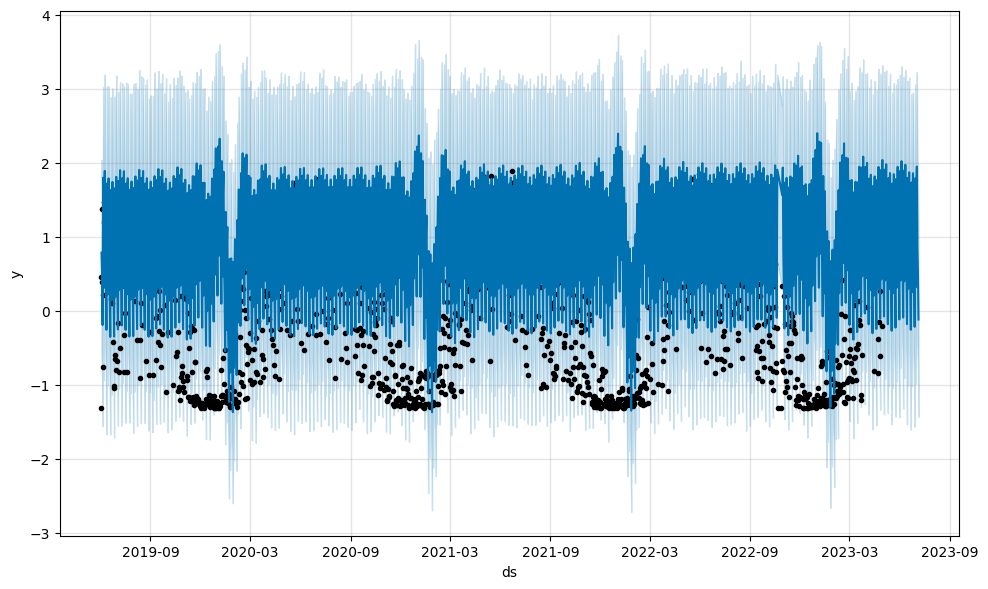

In [36]:
m = Prophet(**best_params)
m.fit(max_values_per_day)
future = m.make_future_dataframe(periods=66, freq='H')
fig1 = m.plot(forecast)